#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 15
**CH15A Predicting used car value with regression trees**

using the used-cars dataset

version 0.9.0 2025-08-14

In [44]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import pyfixest as pf
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from skmisc.loess import loess

warnings.filterwarnings("ignore")

In [45]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/used-cars/clean/"
data_out = dirname + "da_case_studies/ch15-used-cars-cart/"
output = dirname + "da_case_studies/ch15-used-cars-cart/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [46]:
# Import the prewritten helper functions
import py_helper_functions as da

sns.set_theme(rc=da.da_theme, palette=da.color)

In [47]:
# DATA IMPORT
data = pd.read_csv(data_in + "used-cars_2cities_prep.csv")
# data = pd.read_csv("https://osf.io/7gvz9/download")

In [48]:
data.head()

,pricestr,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE,Hybrid
0,$4990,chicago,chicago city,2007 Toyota Camry Hybrid,good,4 cylinders,fwd,gas,11.6236,grey,...,1,4990,8.515191,2007,11,2.453038,0,0,0,1
1,$10625,chicago,chicago city,2009 Toyota Camry Hybrid,NaN,4 cylinders,fwd,hybrid,4.3702,grey,...,1,10625,9.270965,2009,9,1.474809,0,0,0,1
2,$14850,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,NaN,gas,3.5721,NaN,...,1,14850,9.605755,2015,3,1.273154,0,0,0,0
3,$15630,chicago,chicago city,2016 TOYOTA CAMRY,NaN,NaN,fwd,gas,1.3152,NaN,...,1,15630,9.656947,2016,2,0.273989,0,0,0,0
4,$850,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.7000,red,...,0,850,6.745236,1993,25,2.928523,0,0,0,0


In [49]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")

In [50]:
data.head()

,pricestr,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE,Hybrid
0,$4990,chicago,chicago city,2007 Toyota Camry Hybrid,good,4 cylinders,fwd,gas,11.6236,grey,...,1,4990,8.515191,2007,11,2.453038,0,0,0,1
1,$10625,chicago,chicago city,2009 Toyota Camry Hybrid,NaN,4 cylinders,fwd,hybrid,4.3702,grey,...,1,10625,9.270965,2009,9,1.474809,0,0,0,1
2,$14850,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,Missing,gas,3.5721,NaN,...,1,14850,9.605755,2015,3,1.273154,0,0,0,0
3,$15630,chicago,chicago city,2016 TOYOTA CAMRY,NaN,Missing,fwd,gas,1.3152,NaN,...,1,15630,9.656947,2016,2,0.273989,0,0,0,0
4,$850,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.7000,red,...,0,850,6.745236,1993,25,2.928523,0,0,0,0


In [51]:
data["condition"].value_counts()

condition
excellent    139
good         114
like new      55
fair          15
new            4
Name: count, dtype: int64

In [52]:
data["condition"] = data["condition"].fillna("good")

In [53]:
data["condition"].value_counts()

condition
good         336
excellent    139
like new      55
fair          15
new            4
Name: count, dtype: int64

In [54]:
# Drop hybrid models and the 'Hybrid' column
data = data.loc[lambda df: df["Hybrid"] == 0].drop(columns=["Hybrid"])

# Keep only gas-fueled vehicles
data = data.loc[lambda df: df["fuel"] == "gas"]

# Drop vehicles in fair and new condition
data = data.loc[lambda df: ~df["condition"].isin(["new", "fair"])]

# Drop unrealistic values for price and odometer reading
data = data.loc[lambda df: df["price"].between(500, 25000) & (df["odometer"] <= 100)]

# Drop if price is smaller than 1000 and condition is 'like new' or age is less than 8
data = data.loc[
    lambda df: ~(
        (df["price"] < 1000) & ((df["condition"] == "like new") | (df["age"] < 8))
    )
]

# Drop manual transmission
data = data.loc[lambda df: df["transmission"] != "manual"]

# Drop trucks and pickups
data = data.loc[lambda df: ~df["type"].isin(["truck", "pickup"])]

# Drop 'pricestr' column
data = data.drop(columns=["pricestr"])

In [55]:
data.head()

,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,size,...,type,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE
2,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,Missing,gas,3.572100,NaN,NaN,...,sedan,1,14850,9.605755,2015,3,1.273154,0,0,0
3,chicago,chicago city,2016 TOYOTA CAMRY,good,Missing,fwd,gas,1.315200,NaN,NaN,...,sedan,1,15630,9.656947,2016,2,0.273989,0,0,0
4,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.700000,red,full-size,...,sedan,0,850,6.745236,1993,25,2.928523,0,0,0
6,chicago,chicago city,1998 toyota camry le,good,Missing,Missing,gas,16.824259,NaN,NaN,...,Missing,0,1600,7.377759,1998,20,2.822822,1,0,0
7,chicago,chicago city,1998 Toyota Camry,good,Missing,Missing,gas,16.824259,NaN,NaN,...,Missing,0,1500,7.313220,1998,20,2.822822,0,0,0


In [56]:
# to be on the safe side
data = data[data["price"].notna()]
data = data.reset_index(drop=True)

In [57]:
data.head()

,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,size,...,type,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE
0,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,Missing,gas,3.572100,NaN,NaN,...,sedan,1,14850,9.605755,2015,3,1.273154,0,0,0
1,chicago,chicago city,2016 TOYOTA CAMRY,good,Missing,fwd,gas,1.315200,NaN,NaN,...,sedan,1,15630,9.656947,2016,2,0.273989,0,0,0
2,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.700000,red,full-size,...,sedan,0,850,6.745236,1993,25,2.928523,0,0,0
3,chicago,chicago city,1998 toyota camry le,good,Missing,Missing,gas,16.824259,NaN,NaN,...,Missing,0,1600,7.377759,1998,20,2.822822,1,0,0
4,chicago,chicago city,1998 Toyota Camry,good,Missing,Missing,gas,16.824259,NaN,NaN,...,Missing,0,1500,7.313220,1998,20,2.822822,0,0,0


In [58]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# chicago
data["chicago"] = np.where(data["area"] == "chicago", 1, 0)
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 3
data.to_csv("usedcars_work.csv", index=False)

In [59]:
data.head()

,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,size,...,XLE,SE,cond_excellent,cond_good,cond_likenew,cylind6,chicago,agesq,agecu,odometersq
0,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,Missing,gas,3.572100,NaN,NaN,...,0,0,1,0,0,0,1,9,27,45.579633
1,chicago,chicago city,2016 TOYOTA CAMRY,good,Missing,fwd,gas,1.315200,NaN,NaN,...,0,0,0,1,0,0,1,4,8,2.274969
2,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.700000,red,full-size,...,0,0,0,1,0,1,1,625,15625,6539.203000
3,chicago,chicago city,1998 toyota camry le,good,Missing,Missing,gas,16.824259,NaN,NaN,...,0,0,0,1,0,0,1,400,8000,4762.202089
4,chicago,chicago city,1998 Toyota Camry,good,Missing,Missing,gas,16.824259,NaN,NaN,...,0,0,0,1,0,0,1,400,8000,4762.202089


In [60]:
data.price.describe()

count      477.000000
mean      5843.878407
std       4334.571604
min        500.000000
25%       2500.000000
50%       4400.000000
75%       8300.000000
max      18500.000000
Name: price, dtype: float64

### 🕵️‍♀️ Bellonda's Logic Decoder: The Validation Split
**The Syntax Anatomy:**
* `train_test_split(...)` (**The Separator**) $\to$ Returns a `Tuple`
* `test_size=0.3`: Defines the "Exam" difficulty (30% of data unseen).
* `random_state=123`: **The Seed**. Ensures every student gets the exact same shuffle.

**Data Flow:** `(All Cars)` $\to$ `(Training Set: 70%)` + `(Holdout/Test Set: 30%)`
**Student Note:** NEVER change the `random_state` if you want your results to match the textbook numbers!

In [61]:

data_train, data_test = train_test_split(data, test_size=0.3, random_state=123)

In [62]:
data_train.head()

,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,size,...,XLE,SE,cond_excellent,cond_good,cond_likenew,cylind6,chicago,agesq,agecu,odometersq
386,los angeles,central LA,2006 Toyota camry,good,4 cylinders,fwd,gas,13.1000,white,compact,...,0,0,0,1,0,0,0,144,1728,2248.091000
189,chicago,chicago N,2014 Toyota Camry,good,4 cylinders,fwd,gas,4.7536,silver,mid-size,...,0,0,0,1,0,0,1,16,64,107.415735
414,los angeles,central LA,2007 toyota camry,excellent,4 cylinders,Missing,gas,12.0000,white,NaN,...,0,0,1,0,0,0,0,121,1331,1728.000000
267,chicago,chicago S,2003 toyota camry,good,Missing,Missing,gas,23.0000,NaN,NaN,...,0,0,0,1,0,0,1,225,3375,12167.000000
286,chicago,chicago S,2003 TOYOTA CAMRY SOLARA,good,6 cylinders,Missing,gas,15.7000,black,NaN,...,0,0,0,1,0,1,1,225,3375,3869.893000


In [63]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 386 to 365
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   area            333 non-null    object 
 1   subarea         327 non-null    object 
 2   name            333 non-null    object 
 3   condition       333 non-null    object 
 4   cylinders       333 non-null    object 
 5   drive           333 non-null    object 
 6   fuel            333 non-null    object 
 7   odometer        333 non-null    float64
 8   paintcolor      194 non-null    object 
 9   size            119 non-null    object 
 10  transmission    333 non-null    object 
 11  type            333 non-null    object 
 12  dealer          333 non-null    int64  
 13  price           333 non-null    int64  
 14  lnprice         333 non-null    float64
 15  year            333 non-null    int64  
 16  age             333 non-null    int64  
 17  lnodometer      333 non-null    float6

### Regression tree
---

In [64]:
data_train["price"].describe()

count      333.000000
mean      5883.390390
std       4392.305442
min        500.000000
25%       2500.000000
50%       4499.000000
75%       7899.000000
max      18500.000000
Name: price, dtype: float64

### 🕵️‍♀️ Bellonda's Logic Decoder: The Decision Stump (Depth=1)
**The Syntax Anatomy:**
* `DecisionTreeRegressor(...)` (**The Model Archetype**)
* `max_depth=1`: "Ask only ONE question." (Creates a stump, not a full tree).
* `data[[...]]`: **Dimensionality Promotion**. Forces a Series (1D) into a Matrix (2D).

**Data Flow:** `(Age Column)` $\to$ `[CART Algorithm]` $\to$ `(Single Split Rule)`
**Student Note:** The double brackets `[["age"]]` are mandatory. Sklearn refuses to learn from a simple list; it demands a Matrix.

In [65]:
cart1 = DecisionTreeRegressor(random_state=20108, max_depth=1)

# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart1.fit(X, Y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,20108
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [66]:
X.shape

(333, 1)

In [67]:
#check
check = data_train[["age"]]
print(type(check))

<class 'pandas.core.frame.DataFrame'>


### 🕵️‍♀️ Bellonda's Logic Decoder: Model Inference & Evaluation
**The Syntax Anatomy:**
* `cart1` (**Trained Model**) $\to$ `.predict()` (**Inference**)
* `[["age"]]`: **Double Brackets** enforce a 2D DataFrame structure (Matrix), required by sklearn.

**Data Flow:** `(N_rows, 1_feature)` $\to$ `(N_rows, 1_prediction_vector)` $\to$ `Scalar (RMSE)`
**Student Note:** The RMSE tells you the average error in *dollars*. If RMSE = 3000, your model is, on average, off by $3,000.

### 🕵️‍♀️ Bellonda's Logic Decoder: Object Types
* `data_test[["age"]]`: **DataFrame** (2D Matrix) $\to$ The Input $X$
* `pred_cart1`: **Numpy Array** (1D Vector) $\to$ The Prediction $\hat{y}$
* `data_test["price"]`: **Pandas Series** $\to$ The Truth $y$

In [68]:
pred_cart1 = cart1.predict(data_test[["age"]])

rmse_cart1 = root_mean_squared_error(data_test["price"], pred_cart1)

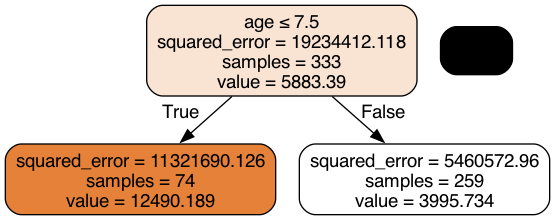

In [69]:
da.plot_decision_tree(
    cart1, filled=True, rounded=True, special_characters=True, feature_names=["age"]
)

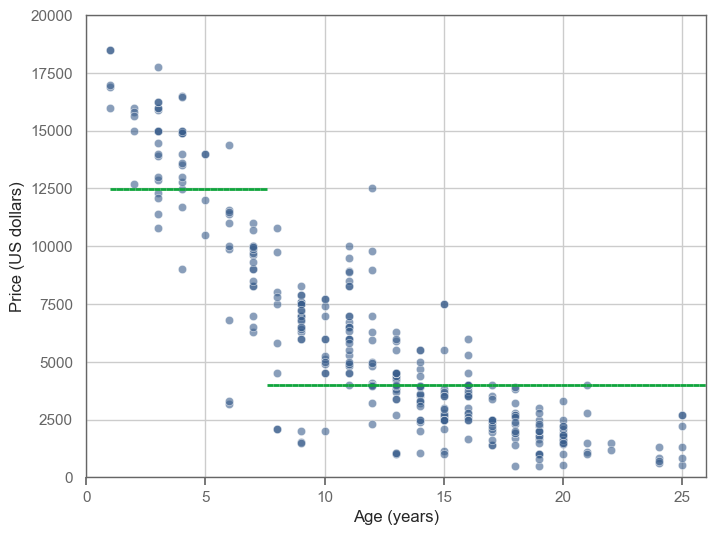

In [70]:
da.plot_model_predictions(cart1, data_train, "age", "price")

In [71]:
###########
# Splits at two levels
# (make sure it stops by setting "max_depth" to 2)

In [72]:
cart2 = DecisionTreeRegressor(random_state=2018, max_depth=2)
# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]] #a df not a series
Y = data_train["price"]
cart2.fit(X, Y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,2018
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


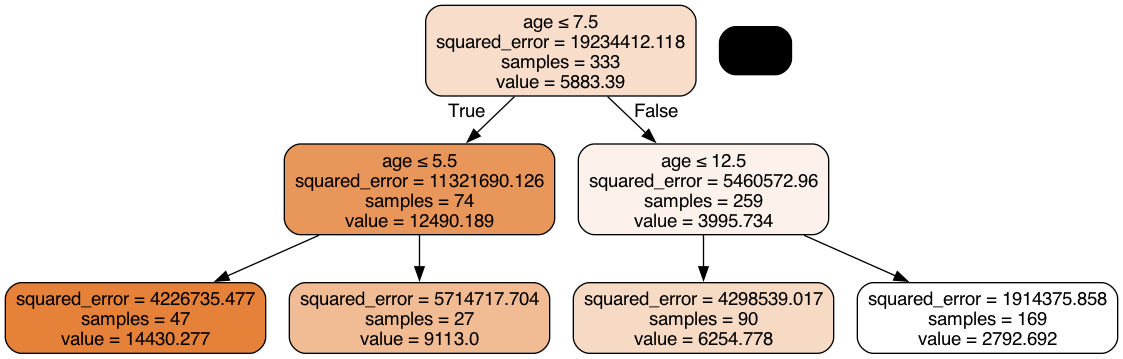

In [73]:
da.plot_decision_tree(
    cart2, filled=True, rounded=True, special_characters=True, feature_names=["age"]
)

In [74]:
(
    data_train[["age"]]
    .assign(Average_price=cart2.predict(X))
    .groupby("Average_price")
    .agg(age_min=("age", "min"), age_max=("age", "max"), Count=("age", "count"))
    .reset_index()
    .sort_values("age_min")
    .assign(
        Category=lambda x: x.apply(
            lambda row: (f"Age {int(row['age_min'])}-{int(row['age_max'])}"),
            axis=1,
        )
    )
    .filter(["Category", "Count", "Average_price"])
    .round(2)
)

,Category,Count,Average_price
3,Age 1-5,47,14430.28
2,Age 6-7,27,9113.00
1,Age 8-12,90,6254.78
0,Age 13-27,169,2792.69


### 🕵️‍♀️ Bellonda's Logic Decoder: [Tree Interval Reconstruction]
**The Syntax Anatomy:**
* `data_train` (**Subject**) $\to$ `groupby().agg()` (**Collapse to Leaves**)
* `Category=lambda x...`: **Vectorized String Construction** (Creating labels without loops)

**Data Flow:** `(Observations)` $\to$ `(Distinct Price Levels / Tree Leaves)`
**Student Note:** This table proves that a Regression Tree creates a **Step Function**. You will see constant prices for specific age intervals.

In [75]:
# ------------------------------------------------------------------------------
# BELLONDA'S "DECISION TREE DECODER"
# Goal: Turn a black-box Tree Model into a clear "Pricing Menu"
# Strategy: Vectorized grouping (No loops allowed!)
# ------------------------------------------------------------------------------

pricing_menu = (
    data_train[["age"]]  # 1. Start light: Select only the feature we care about
    .assign(
        # 2. THE PREDICTION
        # We attach the model's "opinion" directly to the data.
        # This creates a map: Actual Age <--> Predicted Price
        Average_price=cart2.predict(X)
    )
    .groupby("Average_price")  # 3. THE PIVOT: Group by the *Prediction*
    .agg(
        # 4. THE AGGREGATION
        # "For everyone predicted at $10k, what are their ages?"
        age_min=("age", "min"),   # Youngest in this bracket
        age_max=("age", "max"),   # Oldest in this bracket
        Count=("age", "count")    # How many cars justify this rule?
    )
    .reset_index()            # Kick 'Average_price' back to a column so we can use it
    .sort_values("age_min")   # Sort logic: Youngest -> Oldest
    .assign(
        # 5. THE POLISH (Vectorized String Construction)
        # We build the human-readable label instantly for the whole column.
        # Logic: "Age " + Min + "-" + Max
        Category=lambda x: (
            "Age " 
            + x["age_min"].astype(int).astype(str) 
            + "-" 
            + x["age_max"].astype(int).astype(str)
        )
    )
    # 6. FINAL CLEANUP
    # Keep only what the business user needs to see.
    .filter(["Category", "Count", "Average_price"])
    .round(2) 
)

# 7. THE REVEAL
pricing_menu

,Category,Count,Average_price
3,Age 1-5,47,14430.28
2,Age 6-7,27,9113.00
1,Age 8-12,90,6254.78
0,Age 13-27,169,2792.69


In [76]:
data_train.loc[(data_train.age > 1) & (data_train.age < 12), :].shape

(144, 29)

In [77]:
pred_cart2 = cart2.predict(data_test[["age"]])

rmse_cart2 = root_mean_squared_error(data_test["price"], pred_cart2)

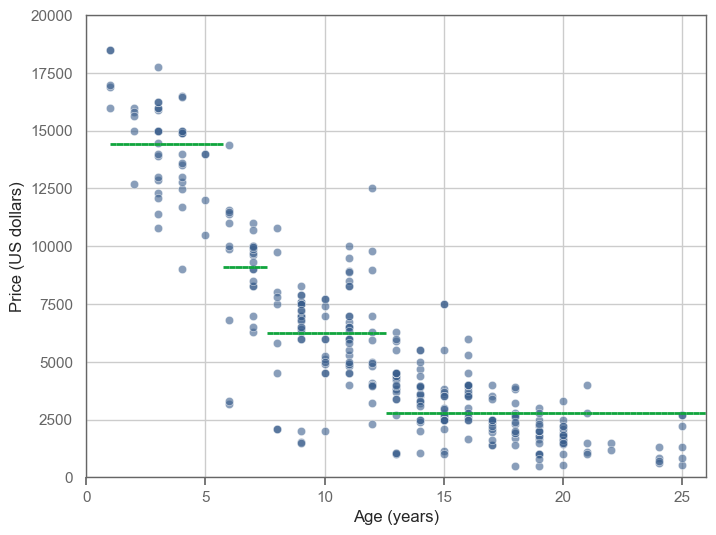

In [78]:
da.plot_model_predictions(cart2, data_train, "age", "price")

**Note**: min_impurity_decrease in sklearn is considered to be the same as cp in caret, the actual values are different but the purpose is the same

In [79]:
cart3 = DecisionTreeRegressor(random_state=2018, min_impurity_decrease=50000)
# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart3.fit(X, Y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,2018
,max_leaf_nodes,None
,min_impurity_decrease,50000
,ccp_alpha,0.0


In [80]:
pred_cart3 = cart3.predict(data_test[["age"]])

rmse_cart3 = root_mean_squared_error(data_test["price"], pred_cart3)
rmse_cart3

2266.1958643489297

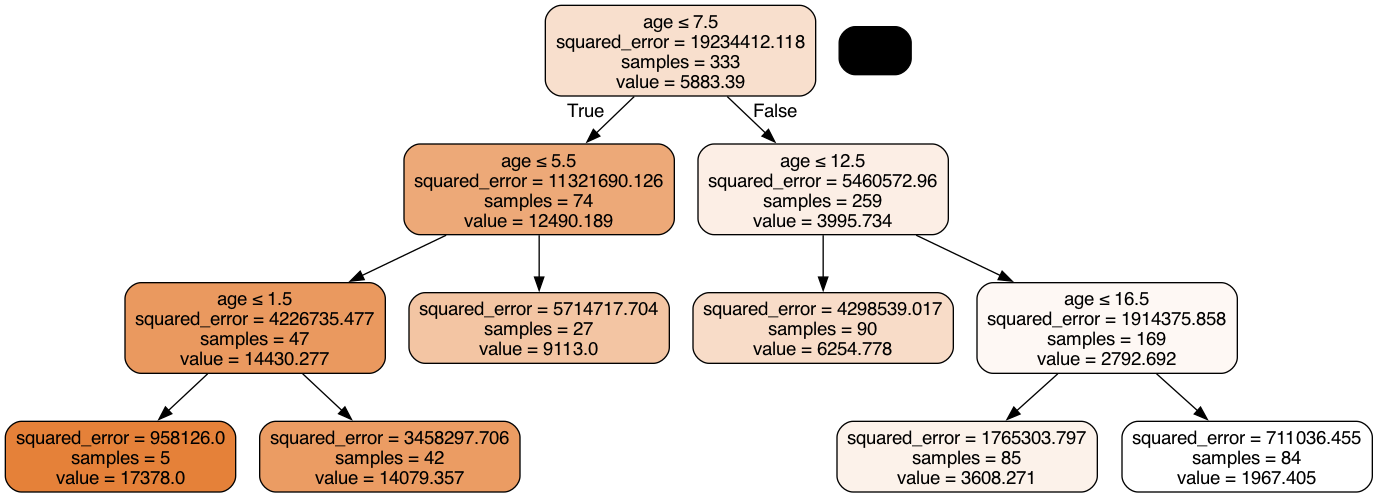

In [81]:
da.plot_decision_tree(
    cart3, filled=True, rounded=True, special_characters=True, feature_names=["age"]
)

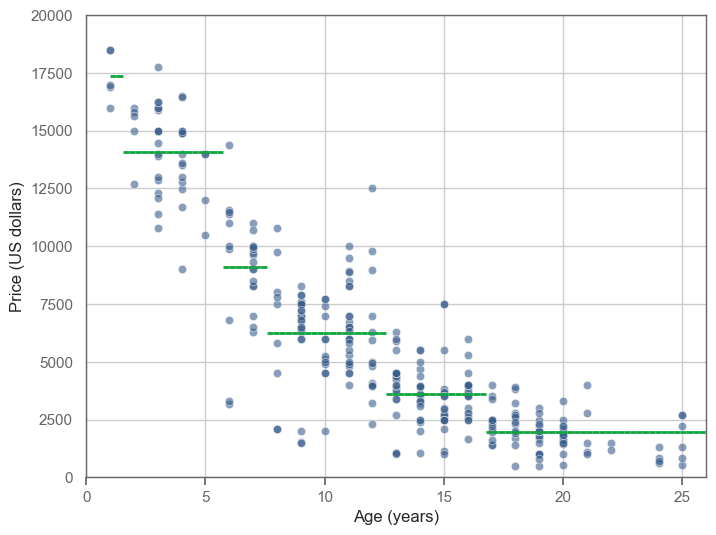

In [82]:
da.plot_model_predictions(cart3, data_train, "age", "price")

#### Age only linear regression
---

In [83]:
linreg1 = pf.feols("price~age", data=data_train)
linreg1.summary()

###

Estimation:  OLS
Dep. var.: price, Fixed effects: 0
Inference:  iid
Observations:  333

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |      2.5% |     97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|----------:|----------:|
| Intercept     |  13998.028 |      291.555 |    48.012 |      0.000 | 13424.493 | 14571.562 |
| age           |   -655.390 |       21.353 |   -30.693 |      0.000 |  -697.395 |  -613.386 |
---
RMSE: 2236.277 R2: 0.74 


In [84]:
pred_linreg1 = linreg1.predict(data_test)
rmse_ols1 = root_mean_squared_error(data_test["price"], pred_linreg1)
rmse_ols1

2433.387411077362

In [85]:
## Scatterplot with predicted values
pred_linreg1t = linreg1.predict(data_train)

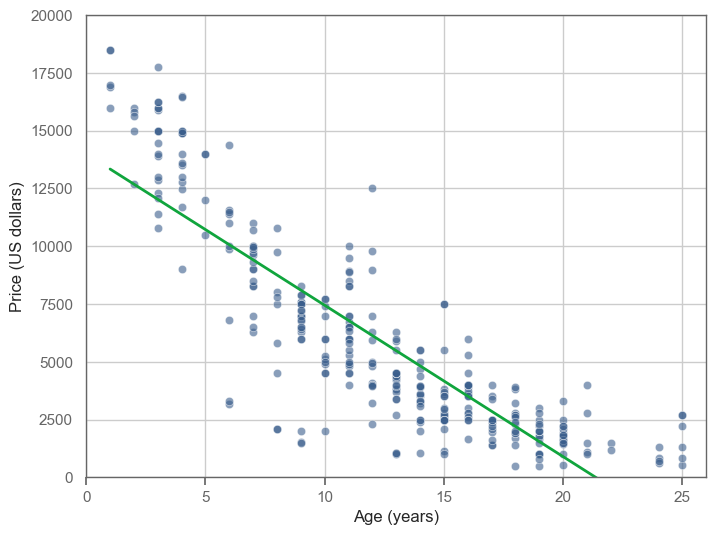

In [86]:
da.plot_model_predictions(linreg1, data_train, "age", "price")

In [87]:
#### Age only only lowess

loess_model = loess(data["age"], data["price"], span=0.8)
loess_model.fit()

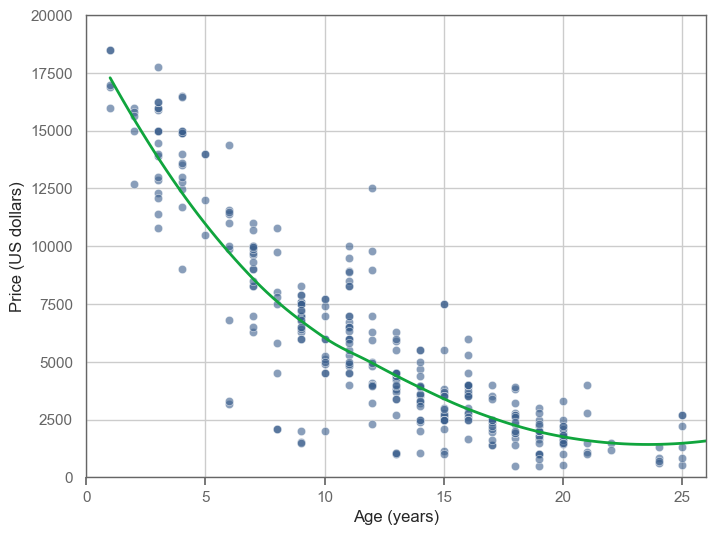

In [88]:
da.plot_model_predictions(loess_model, data_train, "age", "price")

### MULTIPLE PREDICTOR VARIABLES

In [89]:
# Linear regression with multiple variables
model2_X_vars = [
    "age",
    "odometer",
    "LE",
    "XLE",
    "SE",
    "cond_excellent",
    "cond_good",
    "cylind6",
    "dealer",
    "chicago",
]
model2 = "price ~ " + " + ".join(model2_X_vars)
linreg2 = pf.feols(model2, data_train)
linreg2.summary()

###

Estimation:  OLS
Dep. var.: price, Fixed effects: 0
Inference:  iid
Observations:  333

| Coefficient    |   Estimate |   Std. Error |   t value |   Pr(>|t|) |      2.5% |     97.5% |
|:---------------|-----------:|-------------:|----------:|-----------:|----------:|----------:|
| Intercept      |  14537.565 |      421.738 |    34.471 |      0.000 | 13707.856 | 15367.274 |
| age            |   -406.927 |       26.376 |   -15.428 |      0.000 |  -458.818 |  -355.035 |
| odometer       |   -297.295 |       28.533 |   -10.419 |      0.000 |  -353.430 |  -241.161 |
| LE             |   -278.003 |      242.505 |    -1.146 |      0.252 |  -755.097 |   199.090 |
| XLE            |    832.285 |      411.751 |     2.021 |      0.044 |    22.223 |  1642.346 |
| SE             |    570.647 |      339.578 |     1.680 |      0.094 |   -97.425 |  1238.719 |
| cond_excellent |   -698.571 |      387.590 |    -1.802 |      0.072 | -1461.100 |    63.958 |
| cond_good      |   -269.385 |      370.57

In [90]:
pred_linreg2 = linreg2.predict(data_test)
rmse_linreg2 = root_mean_squared_error(data_test["price"], pred_linreg2)
rmse_linreg2

2111.8718818340735

In [91]:
# add squared for age, odometer
model3_X_vars = [
    "age",
    "agesq",
    "odometer",
    "odometersq",
    "LE",
    "XLE",
    "SE",
    "cond_excellent",
    "cond_good",
    "cylind6",
    "dealer",
    "chicago",
]
model3 = "price ~ " + " + ".join(model3_X_vars)
linreg3 = pf.feols(model3, data_train)
linreg3.summary()

###

Estimation:  OLS
Dep. var.: price, Fixed effects: 0
Inference:  iid
Observations:  333

| Coefficient    |   Estimate |   Std. Error |   t value |   Pr(>|t|) |      2.5% |     97.5% |
|:---------------|-----------:|-------------:|----------:|-----------:|----------:|----------:|
| Intercept      |  17970.398 |      409.784 |    43.853 |      0.000 | 17164.186 | 18776.610 |
| age            |   -989.111 |       69.740 |   -14.183 |      0.000 | -1126.319 |  -851.904 |
| agesq          |     21.780 |        2.397 |     9.085 |      0.000 |    17.063 |    26.496 |
| odometer       |   -408.816 |       41.977 |    -9.739 |      0.000 |  -491.402 |  -326.230 |
| odometersq     |      0.297 |        0.055 |     5.420 |      0.000 |     0.190 |     0.405 |
| LE             |     -1.787 |      190.788 |    -0.009 |      0.993 |  -377.143 |   373.570 |
| XLE            |    434.832 |      323.214 |     1.345 |      0.179 |  -201.062 |  1070.725 |
| SE             |    341.001 |      267.67

In [92]:
pred_linreg3 = linreg3.predict(data_test)
rmse_linreg3 = root_mean_squared_error(data_test["price"], pred_linreg3)
rmse_linreg3

1857.9550850322616

In [93]:
from sklearn.preprocessing import OneHotEncoder

In [94]:
OneHotEncoder().fit_transform(data_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9657 stored elements and shape (333, 1359)>

In [95]:
# Tree

# Splits at four levels, for illustrative purposes
# (make sure it stops by setting "maxdepth" to 3)

X = data_train[model2_X_vars]
y = data_train["price"]
X_test = data_test[model2_X_vars]
y_test = data_test["price"]

cart4 = DecisionTreeRegressor(random_state=20108, max_depth=3)
cart4.fit(X, y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,20108
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [96]:
pred_cart4 = cart4.predict(X_test)
rmse_cart4 = root_mean_squared_error(y_test, pred_cart4)
rmse_cart4

2051.1691218693722

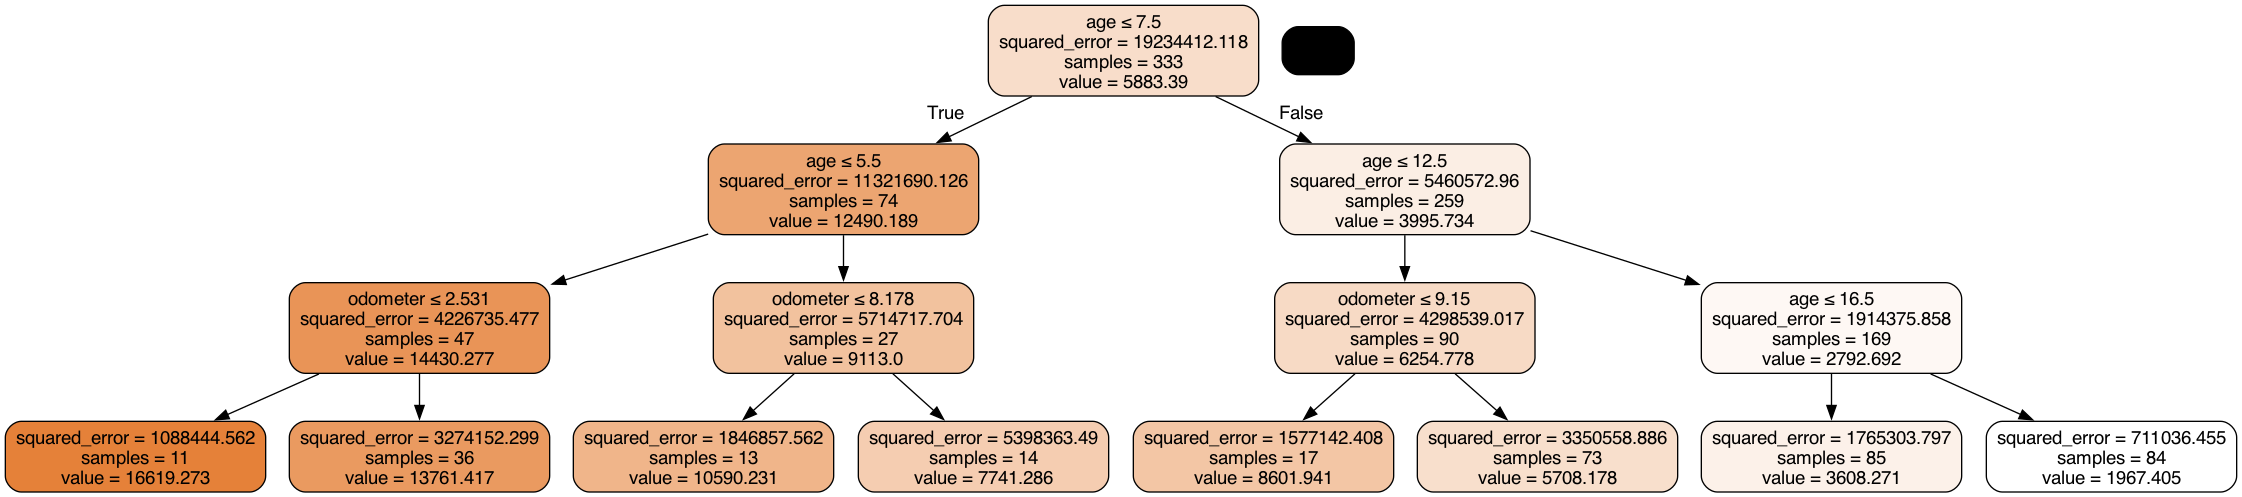

In [97]:
da.plot_decision_tree(
    cart4,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=model2_X_vars,
)

In [98]:
# alternative to show the use of min_impurity_decrease
# slightly the same outcome

In [99]:
cart4 = DecisionTreeRegressor(
    random_state=20108,
    min_impurity_decrease=145000,
    min_samples_split=20,
)
cart4.fit(X, Y)

pred_cart4 = cart4.predict(X_test)
rmse_cart4 = root_mean_squared_error(y_test, pred_cart4)
rmse_cart4

2051.1691218693722

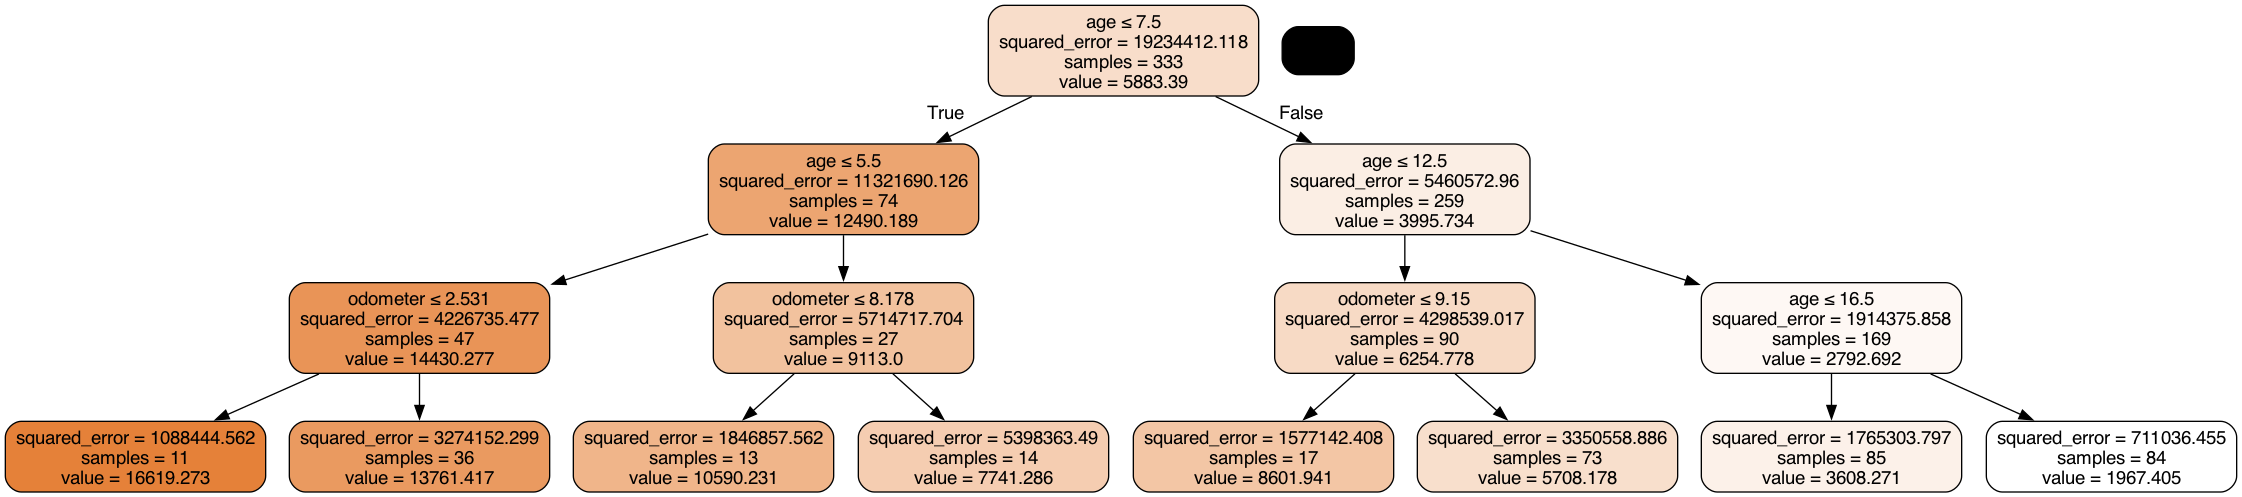

In [100]:
da.plot_decision_tree(
    cart4,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=model2_X_vars,
)

In [101]:
# CART M5
cart5 = DecisionTreeRegressor(random_state=20108, min_impurity_decrease=20000)
cart5.fit(X, Y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,20108
,max_leaf_nodes,None
,min_impurity_decrease,20000
,ccp_alpha,0.0


In [102]:
pred_cart5 = cart5.predict(X_test)
rmse_cart5 = root_mean_squared_error(y_test, pred_cart5)
rmse_cart5

2230.3702214698933

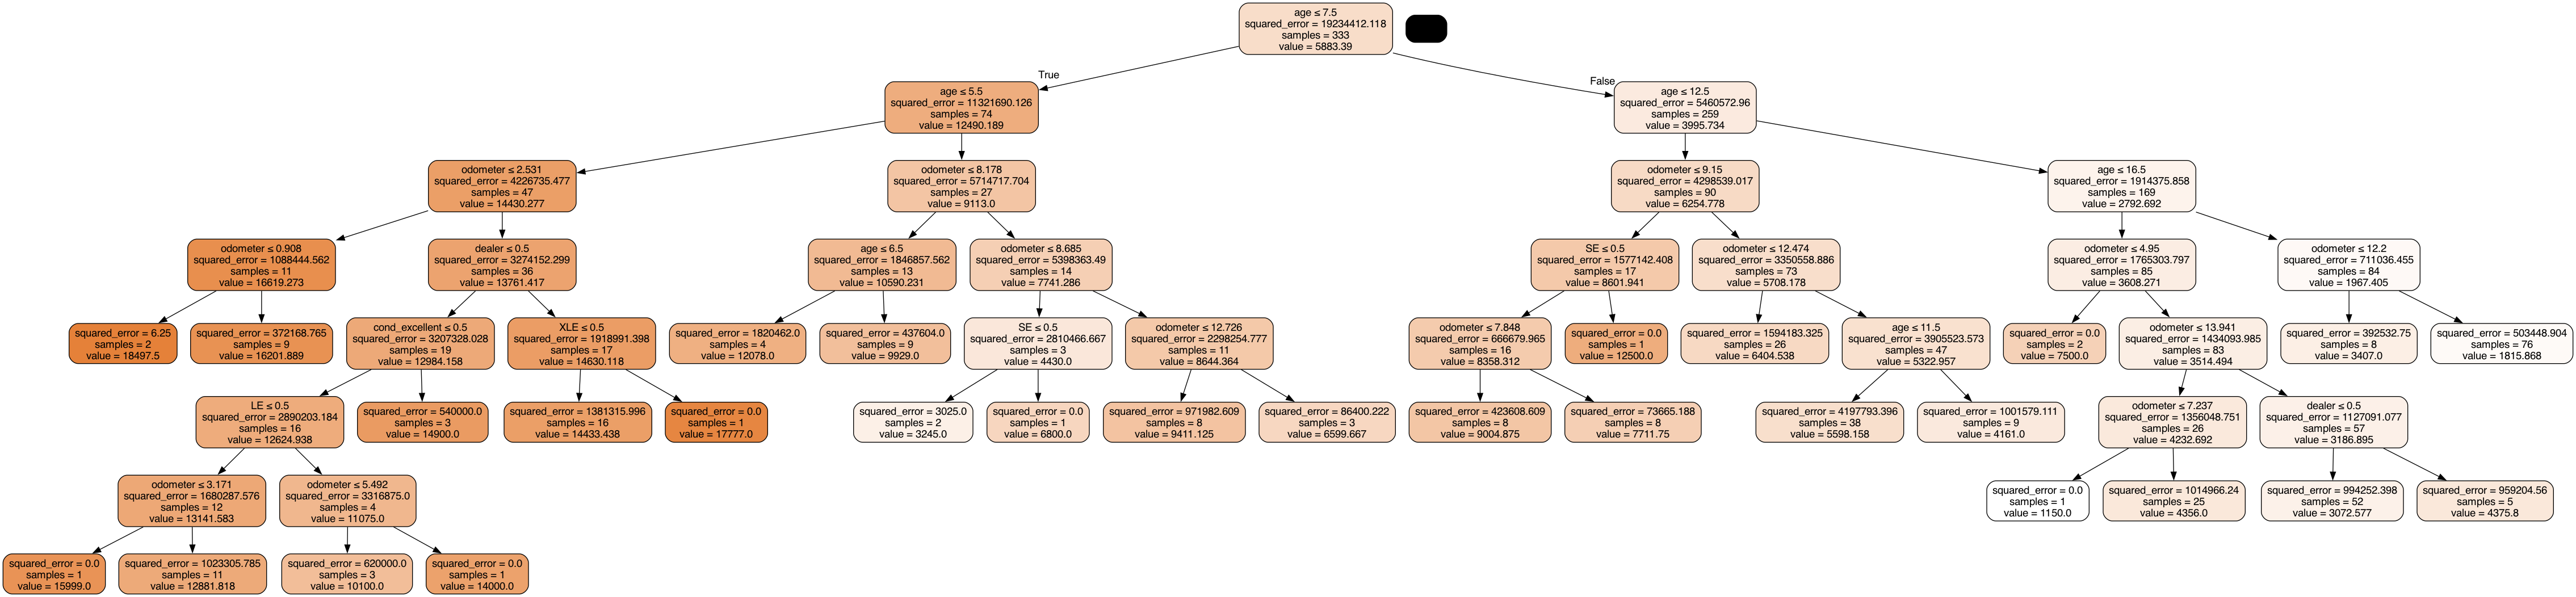

In [103]:
da.plot_decision_tree(
    cart5,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=model2_X_vars,
)

In [104]:
# build very large tree and prune it
# in Python this can be done in sklearn's DecisionTreeRegressor with ccp_alpha parameter
cart6 = DecisionTreeRegressor(random_state=20108, min_samples_split=4, ccp_alpha=30000)
cart6.fit(X, Y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,4
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,20108
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,30000


In [105]:
pred_cart6 = cart6.predict(X_test)
rmse_cart6 = root_mean_squared_error(y_test, pred_cart6)
rmse_cart6

2036.2688014814048

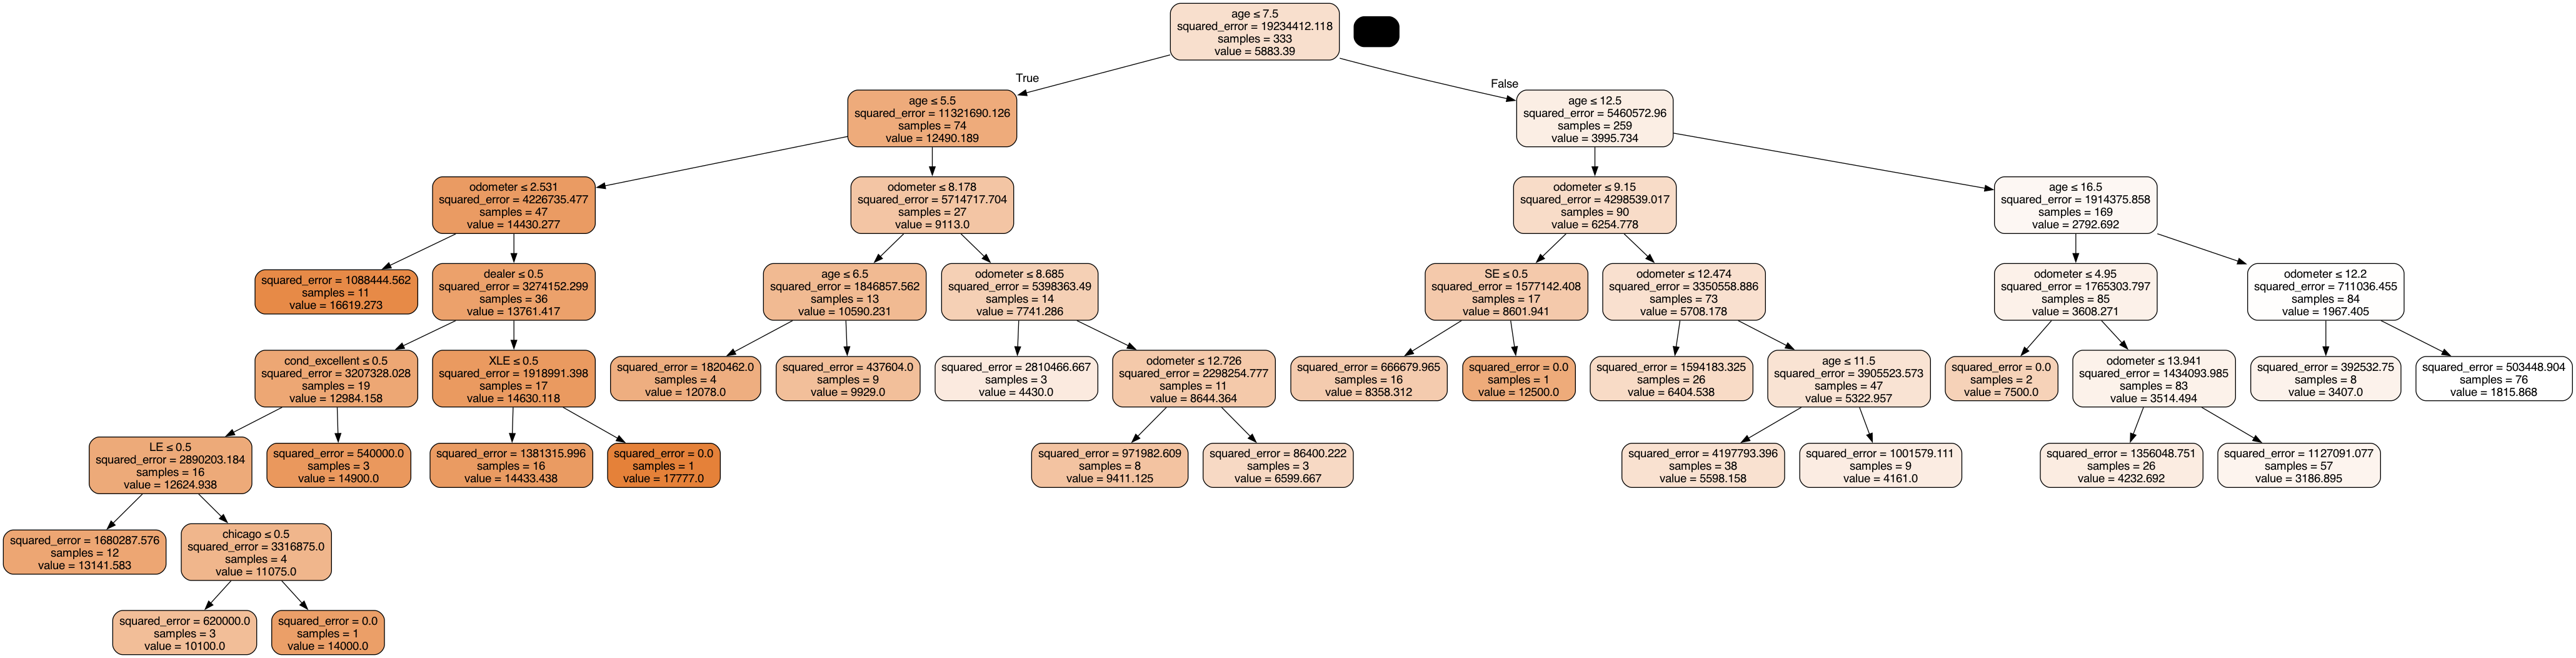

In [106]:
da.plot_decision_tree(
    cart6,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=model2_X_vars,
)

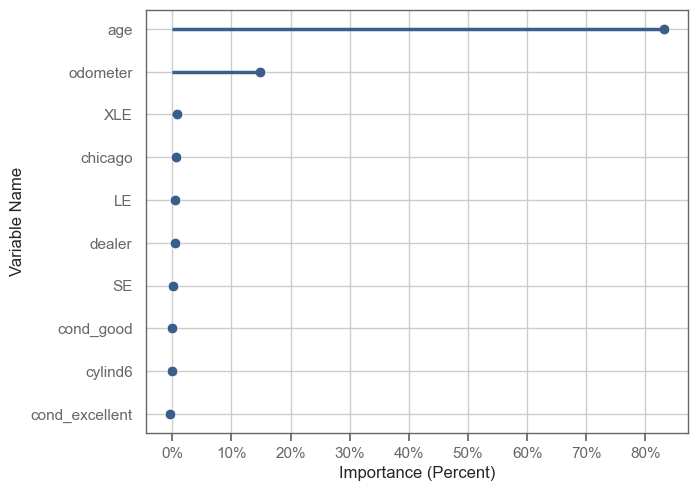

In [107]:
# Variable (permutation) importance for model 6 (not in book)

perm_imp = permutation_importance(
    cart6,
    X_test,
    y_test,
    n_repeats=100,
    scoring="neg_root_mean_squared_error",
    random_state=20108,
)

cart6_var_imp_df = pd.DataFrame(
    [perm_imp["importances_mean"], X_test.columns],
    index=["imp", "varname"],
).T.assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())

da.plot_variable_importance(cart6_var_imp_df)

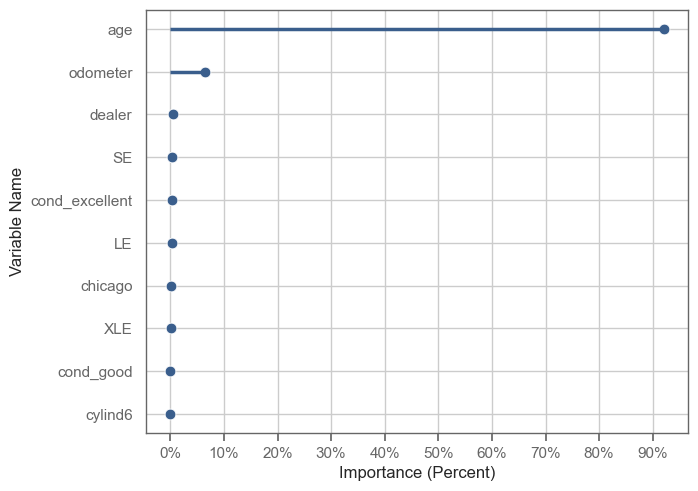

In [108]:
# Variable importance for model 6

cart6_var_imp_df = pd.DataFrame(
    [cart6.feature_importances_, X_test.columns],
    index=["imp", "varname"],
).T.assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())

da.plot_variable_importance(cart6_var_imp_df)

In [109]:
pd.DataFrame(
    {
        "Model": ["CART M" + str(i) for i in range(1, 7)]
        + ["OLS M" + str(i) for i in range(1, 4)],
        "Number of variables": [1, 1, 7, 7, 7, 7, 1, 7, 7],
        "Model details": [
            "2 levels",
            "3 levels",
            "min_impurity_decrease=50000",
            "min_impurity_decrease=140000 & min_samples_split=20",
            "min_impurity_decrease=20000",
            "ccp_alpha=30000",
            "linear",
            "linear",
            "w/ polynomial terms",
        ],
        "RMSE": [
            rmse_cart1,
            rmse_cart2,
            rmse_cart3,
            rmse_cart4,
            rmse_cart5,
            rmse_cart6,
            rmse_ols1,
            rmse_linreg2,
            rmse_linreg3,
        ],
    }
).set_index("Model").round(2)

,Number of variables,Model details,RMSE
Model,,,
CART M1,1,2 levels,2785.05
CART M2,1,3 levels,2381.82
CART M3,7,min_impurity_decrease=50000,2266.20
CART M4,7,min_impurity_decrease=140000 & min_samples_spl...,2051.17
CART M5,7,min_impurity_decrease=20000,2230.37
CART M6,7,ccp_alpha=30000,2036.27
OLS M1,1,linear,2433.39
OLS M2,7,linear,2111.87
OLS M3,7,w/ polynomial terms,1857.96
